# <div style="background-color: cyan; text-align: center;"><font face="verdana" color="red">Importing Libraries

In [1]:
import pathlib,random
import tensorflow as tf
import os, json
from tensorflow.keras.applications import  InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.compat.v1.train import AdamOptimizer
from tensorflow.keras.losses import sparse_categorical_crossentropy
import pickle

# <div style="background-color: cyan; text-align: center;"><font face="verdana" color="red">Importing Training Images

In [2]:
data_root = pathlib.Path('Train_images/')
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)
img_cnt = len(all_image_paths)

# <div style="background-color: cyan; text-align: center;"><font face="verdana" color="red">Defining Labels

In [3]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_to_index = dict((name, index) for index, name in enumerate(label_names))
all_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]

# <div style="background-color: cyan; text-align: center;"><font face="verdana" color="red">Defining Functions to Preprocess Images

In [4]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image /= 255.0
    return image

In [5]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

In [6]:
# os.makedirs('checkpoint')

# <div style="background-color: cyan; text-align: center;"><font face="verdana" color="red">Saving Labels

In [7]:
with open(os.path.join('checkpoint', 'label_to_index.txt'), 'w')as file:
    file.write(json.dumps(label_to_index))

# <div style="background-color: cyan; text-align: center;"><font face="verdana" color="red">Splitting Data into Train and Test Split

In [8]:
train_len = len(all_image_paths)*0.8
train_ds = tf.data.Dataset.from_tensor_slices((all_image_paths[0:int(train_len*0.8)],
                                all_image_labels[0:int(train_len*0.8)]))
val_ds = tf.data.Dataset.from_tensor_slices((all_image_paths[int(train_len*0.8):int(train_len)],
                                all_image_labels[int(train_len*0.8):int(train_len)]))

# <div style="background-color: cyan; text-align: center;"><font face="verdana" color="red">Applying Preprocessing Functions

In [9]:
def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path=path), label

In [10]:
train_label_ds = train_ds.map(load_and_preprocess_from_path_label)
val_label_ds = val_ds.map(load_and_preprocess_from_path_label)

In [11]:
batch_size = 32
autotune = tf.data.experimental.AUTOTUNE

In [12]:
train_ds = train_label_ds.shuffle(buffer_size=int(img_cnt*0.8)).repeat()
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(buffer_size=autotune)

val_ds = val_label_ds.shuffle(buffer_size=int(img_cnt*0.2)).repeat()
val_ds = val_ds.batch(batch_size)
val_ds = val_ds.prefetch(buffer_size=autotune)

# <div style="background-color: cyan; text-align: center;"><font face="verdana" color="red">Building Model using Transfer Learning

In [13]:
inception_model = InceptionV3(include_top=False, input_shape=(224, 224, 3))
inception_model.trainable = False

model = tf.keras.Sequential([
    inception_model,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(202, activation='relu'),
#     Dropout(0.2),
    Dense(202, activation='relu'),
    Dropout(0.2),
    Dense(len(label_names), activation='softmax')
])

# <div style="background-color: cyan; text-align: center;"><font face="verdana" color="red">Applying Learning Rate Schedular to prevent Gradient Explosion <br>& Early Stopping for Overfitting

In [14]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import numpy as np

def lr_schedule(epoch):
    initial_lr = 0.001 
    decay_factor = 0.5 
    epochs_drop = 5    
    new_lr = initial_lr * (decay_factor ** np.floor((1 + epoch) / epochs_drop))
    return new_lr

learning_rate_scheduler = LearningRateScheduler(lr_schedule)

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=3,           
    restore_best_weights=True 
)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss=sparse_categorical_crossentropy, 
              metrics=['accuracy'])

In [15]:
steps_per_epoch = tf.math.ceil(int(len(all_image_paths)*0.8)/batch_size).numpy()
val_step = tf.math.ceil(int(len(all_image_paths)*0.2)/batch_size).numpy()

In [16]:
# checkpoint_path = 'checkpoint/cp-{epoch:04d}.ckpt'
# cp_callback = tf.keras.callbacks.ModelCheckpoint('checkpoint/weightings.h5', verbose=1, save_weights_only=True, save_freq=20)

# <div style="background-color: cyan; text-align: center;"><font face="verdana" color="red">Training and Evaluating Model

In [18]:
history = model.fit(train_ds,
                   epochs=15,
                   steps_per_epoch=steps_per_epoch,
                   validation_data=val_ds,
                   validation_steps=val_step,
                   callbacks=[ learning_rate_scheduler, early_stopping])

Epoch 1/15
74/74 [==============================] - 213s 2s/step - loss: 2.4676 - accuracy: 0.2407 - val_loss: 1.9633 - val_accuracy: 0.3766 - lr: 0.0010
Epoch 2/15
74/74 [==============================] - 155s 2s/step - loss: 1.6525 - accuracy: 0.4713 - val_loss: 1.5333 - val_accuracy: 0.5148 - lr: 0.0010
Epoch 3/15
74/74 [==============================] - 155s 2s/step - loss: 1.1237 - accuracy: 0.6546 - val_loss: 1.1587 - val_accuracy: 0.6135 - lr: 0.0010
Epoch 4/15
74/74 [==============================] - 159s 2s/step - loss: 0.7905 - accuracy: 0.7504 - val_loss: 1.0949 - val_accuracy: 0.6447 - lr: 0.0010
Epoch 5/15
74/74 [==============================] - 157s 2s/step - loss: 0.4611 - accuracy: 0.8649 - val_loss: 0.8707 - val_accuracy: 0.7122 - lr: 5.0000e-04
Epoch 6/15
74/74 [==============================] - 156s 2s/step - loss: 0.3514 - accuracy: 0.9130 - val_loss: 0.8826 - val_accuracy: 0.7204 - lr: 5.0000e-04
Epoch 7/15
74/74 [==============================] - 158s 2s/step - l

# <div style="background-color: cyan; text-align: center;"><font face="verdana" color="red"> Saving Model

In [19]:
tf.keras.models.save_model(model, 'checkpoint/weightings.h5')
with open('checkpoint/history', 'wb')as file:
    pickle.dump(history.history, file)

# <div style="background-color: cyan; text-align: center;"><font face="verdana" color="red">Visualizing Evaluation

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

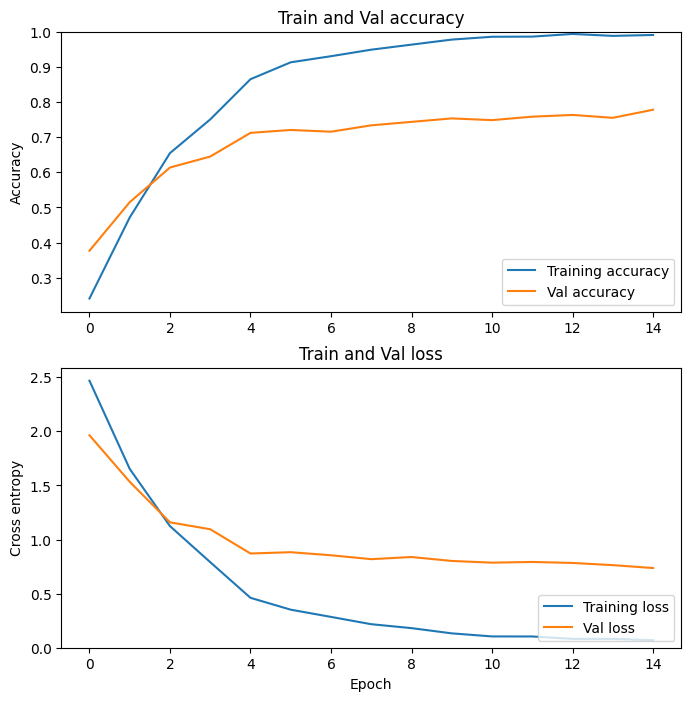

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Val accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Train and Val accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Val loss')
plt.legend(loc='lower right')
plt.ylabel('Cross entropy')
plt.ylim([0, max(plt.ylim())])
plt.title('Train and Val loss')
plt.xlabel('Epoch')
plt.show()

# <div style="background-color: cyan; text-align: center;"><font face="verdana" color="red">Model is undergoing overfitting condition

# <div style="background-color: cyan; text-align: center;"><font face="verdana" color="red">Importing Model

In [22]:
model_ = tf.keras.models.load_model('checkpoint/weightings.h5')

# <div style="background-color: cyan; text-align: center;"><font face="verdana" color="red">Changing Params

In [23]:
def lr_schedule(epoch):
    initial_lr = 0.0000001  # Initial learning rate
    decay_factor = 0.5  # Factor by which the learning rate will be reduced
    epochs_drop = 3    # Number of epochs after which to reduce the learning rate
    new_lr = initial_lr * (decay_factor ** np.floor((1 + epoch) / epochs_drop))
    return new_lr

learning_rate_scheduler = LearningRateScheduler(lr_schedule)

model_.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0000001),
             loss=tf.keras.losses.sparse_categorical_crossentropy,
             metrics=['accuracy'])

In [24]:
# checkpoint_path = 'checkpoint/cp-{epoch:04d}.ckpt'
# cp_callback = tf.keras.callbacks.ModelCheckpoint('checkpoint/weightings.h5', verbose=1, save_weights_only=True, save_freq=20)

In [25]:
steps_per_epoch = tf.math.ceil(int(len(all_image_paths)*0.8)/batch_size).numpy()
val_step = tf.math.ceil(int(len(all_image_paths)*0.2)/batch_size).numpy()

# <div style="background-color: cyan; text-align: center;"><font face="verdana" color="red">Resuming Training

In [26]:
history = model_.fit(train_ds,
                   epochs=20,
                   initial_epoch = 15,
                   steps_per_epoch=steps_per_epoch,
                   validation_data=val_ds,
                   validation_steps=val_step,
                   callbacks=[learning_rate_scheduler,early_stopping])

Epoch 16/20
74/74 [==============================] - 213s 2s/step - loss: 0.3615 - accuracy: 0.9024 - val_loss: 0.2880 - val_accuracy: 0.8997 - lr: 3.1250e-09
Epoch 17/20
74/74 [==============================] - 156s 2s/step - loss: 0.3864 - accuracy: 0.8965 - val_loss: 0.3181 - val_accuracy: 0.8947 - lr: 3.1250e-09
Epoch 18/20
74/74 [==============================] - 159s 2s/step - loss: 0.3547 - accuracy: 0.9033 - val_loss: 0.2979 - val_accuracy: 0.9046 - lr: 1.5625e-09
Epoch 19/20
74/74 [==============================] - 159s 2s/step - loss: 0.3725 - accuracy: 0.9092 - val_loss: 0.2839 - val_accuracy: 0.9046 - lr: 1.5625e-09
Epoch 20/20
74/74 [==============================] - 161s 2s/step - loss: 0.3514 - accuracy: 0.9084 - val_loss: 0.2837 - val_accuracy: 0.8997 - lr: 1.5625e-09


In [27]:
with open('checkpoint/history', 'rb')as file:
    prev_hist = pickle.load(file)

In [28]:
hist_combine = {}
for i in prev_hist:
    hist_combine[i] = prev_hist[i] + history.history[i]

In [29]:
acc = hist_combine['accuracy']
val_acc = hist_combine['val_accuracy']
loss = hist_combine['loss']
val_loss = hist_combine['val_loss']

# <div style="background-color: cyan; text-align: center;"><font face="verdana" color="red">Visualizing Evaluation

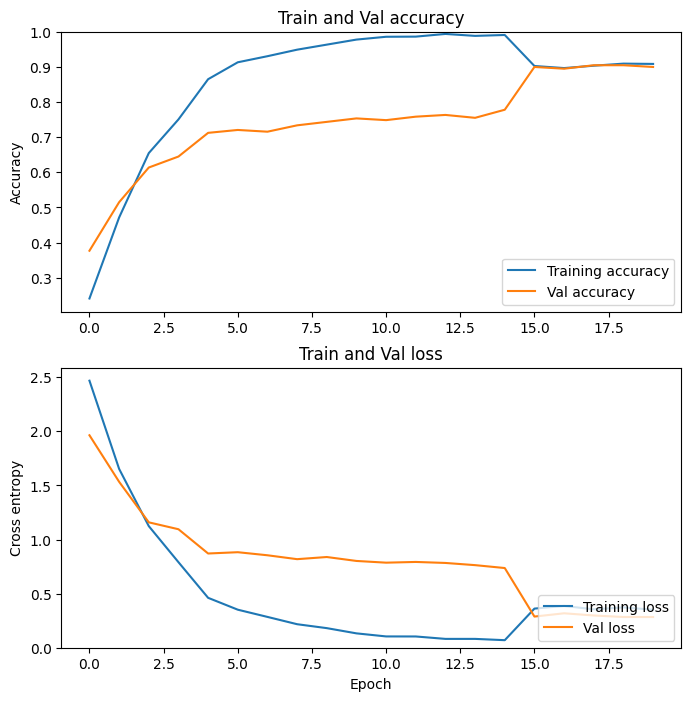

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Val accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Train and Val accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Val loss')
plt.legend(loc='lower right')
plt.ylabel('Cross entropy')
plt.ylim([0, max(plt.ylim())])
plt.title('Train and Val loss')
plt.xlabel('Epoch')
plt.show()

# <div style="background-color: cyan; text-align: center;"><font face="verdana" color="red">Overfitting condition is dismissed and Model seems to excel

# <div style="background-color: cyan; text-align: center;"><font face="verdana" color="red">Saving Model

In [33]:
tf.keras.models.save_model(model_, 'checkpoint/weightings.h5')
with open('checkpoint/history', 'wb')as file:
    pickle.dump(hist_combine, file)